In [29]:
import numpy as np
import pandas as pd
import string
import nltk
import time
import datetime

from collections import Counter

from matplotlib import pyplot as plt

from scipy import sparse

from scipy.stats import wasserstein_distance # earth-mover distance
from scipy.interpolate import BSpline, splrep

from nltk.text import Text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.manifold import TSNE

rng = np.random

In [2]:
# NLTK mandatory downloads for the applications of this NB
nltk.download('stopwords')
nltk.download('punkd')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/giuliano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading punkd: Package 'punkd' not found in index
[nltk_data] Downloading package wordnet to /home/giuliano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
# This is for pandas to write the whole strings
pd.options.display.max_colwidth = 200

In [3]:
df = pd.read_csv('../data/news_headlines.csv', parse_dates=[0], infer_datetime_format=True)

print('Total rows: %d\n10 random rows:' % (len(df)))
df.sample(10)

Total rows: 1000001
10 random rows:


,publish_date,headline_text
815763,2014-04-26,28 killed in attack on shiite political rally ...
462901,2009-02-23,funds performance not so super
849181,2015-06-05,gillard discusses concerns about rudd with ton...
462660,2009-12-29,gayle to boost warriors chase
368631,2008-11-06,nz unemployment hits five year high
760175,2013-10-29,asic head calls for tougher white collar crime...
649992,2012-01-24,gangland figure to deny murder conspiracy
289970,2007-07-16,cold wet weather brings livestock losses
921088,2016-12-10,man charged with murder of eaton woman tanya b...
299352,2007-10-20,motorcyclist badly injured in smash


In [4]:
def preproc(single_headline, reduce='lemmatise', retain='all'):
    '''
    Helper function to use w/ DataFrame.apply that pre-processes
    a headline into its feature-extraction-ready form.
    
    - reduce: lemmatise (default) or stemmise
    - retain: all (default, alphanumeric) or alpha (only alphabetic)
    '''
    words = word_tokenize(single_headline)
    sanitised = []
    reduced = []
    
    # Stop word removal
    for w in words:
        if w not in preproc.en_sw:
            if retain == 'alpha' and w.isalpha():
                sanitised.append(w)
            else:
                sanitised.append(w)
    
    # Stemming/Lemmatising
    if reduce == 'lemmatise':
        reduced = [preproc.wnl.lemmatize(w) for w in sanitised]
    elif reduce == 'stemmise':
        reduced = [preproc.stemmer.stem(w) for w in sanitised]

    return ' '.join(reduced)

preproc.en_sw = set(stopwords.words('english'))
preproc.wnl = WordNetLemmatizer()
preproc.stemmer = SnowballStemmer('english')

In [5]:
df['headline_pprocd'] = df['headline_text'].apply(lambda s: preproc(s))

df.sample(10)

,publish_date,headline_text,headline_pprocd
776656,2014-06-13,emmerson secures joint venture for tennant cre...,emmerson secures joint venture tennant creek g...
121360,2004-11-03,stone argues against restricting abortion,stone argues restricting abortion
313864,2007-01-23,opposition criticises amount of water extracted,opposition criticises amount water extracted
140283,2005-04-18,algal bloom raises shellfish poisoning fears,algal bloom raise shellfish poisoning fear
998313,2017-06-25,evolution torres strait masks exhibit on natio...,evolution torres strait mask exhibit national ...
903147,2015-09-11,noodle guilty,noodle guilty
804364,2014-12-15,myefo commodity prices senate blocks only part...,myefo commodity price senate block part budget...
189413,2005-07-07,opposition sounds warning over upper house mak...,opposition sound warning upper house makeover
640328,2012-02-14,gillard talks to am,gillard talk
441108,2009-03-05,costello tanner set to slug it out on economy,costello tanner set slug economy


In [6]:
# break dataset by year
print('min date = %s\nmax date = %s' % (np.min(df['publish_date']), np.max(df['publish_date'])))

df_year = {}

for y in np.arange(2003, 2018):
    subdf = df[(df['publish_date'] >= datetime.date(y, 1, 1)) & (df['publish_date'] < datetime.date(y+1, 12, 31))]
    df_year[y] = subdf
    
    print('year %d length = %d' % (y, len(subdf)))

df_year.keys()

min date = 2003-02-19 00:00:00
max date = 2017-12-31 00:00:00
year 2003 length = 125152
year 2004 length = 132216
year 2005 length = 127798
year 2006 length = 130835
year 2007 length = 140822
year 2008 length = 140271
year 2009 length = 136412
year 2010 length = 137557
year 2011 length = 148276
year 2012 length = 159428
year 2013 length = 154233
year 2014 length = 143226
year 2015 length = 122101
year 2016 length = 96284
year 2017 length = 44182


dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

## NLTK Text

In [125]:
txt1 = Text(word_tokenize(' '.join(df['headline_text'])))
txt2 = Text(word_tokenize(' '.join(df['headline_pprocd'])))

print('Raw text lexical richness: %.3f' % (len(set(txt1)) / len(txt1)))
print('Pproced text lexical richness: %.3f' % (len(set(txt2)) / len(txt2)))

Raw text lexical richness: 0.013
Pproced text lexical richness: 0.014


In [ ]:
# run this to alleaviate RAM usage
del txt1, txt2

The basics:
- Tokenise
- Remove stop words
- **Remove numbers?**
- Remove punctuation (contains '!', '$' and '&')
- Remove prefixes and suffixes (lemmatise vs stemmise)

Wonders:
- Can I use a synonym dictionary to identify equivalence between words? What about each word being synonym of 2 semantically different words? Any examples?


## Configuration (aka globals)

In [7]:
n_comps = 1000
l_norm = 'l2'
metric = 'minkowski'
p = 2 # for Minkowski metric
stop_words = 'english'

n_topics = 20
subsample_ratio = 0.1
subsample_size = int(subsample_ratio * len(df['headline_pprocd']))

data_year = 2017

# Feature extraction

## n-grams and TF-IDF
The code below is almost a copy-paste from [this sklearn example](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py)

In [171]:
counter = CountVectorizer(ngram_range=(1,2), max_features=5000)
tfidft = TfidfTransformer(smooth_idf=False)
nmf = NMF(n_components=20, init='nndsvd')


In [172]:
#data = df_year[data_year]['headline_pprocd']
data = df['headline_pprocd']

In [173]:
term_matrix = counter.fit_transform(data)

term_matrix.shape

(1000001, 5000)

In [174]:
tfidf_feats = tfidft.fit_transform(term_matrix)

tfidf_feats.shape

(1000001, 5000)

In [175]:
t0 = time.time()
nmf_feats = nmf.fit_transform(tfidf_feats)

print('NMF finished in %.1fs' % (time.time() - t0))
nmf_feats.shape

NMF finished in 137.6s


(1000001, 20)

In [ ]:
# if RAM is needed
del counter, tfidft, term_matrix, tfidf_feats
gc.collect()

## LDA (Latent Dirichlet Allocation)

In [409]:
# data declaration
data = df['headline_pprocd'].sample(subsample_size)

# feature extractors declaration
lda_counter = CountVectorizer(ngram_range=(1, 1), max_features=30000)
lda = LatentDirichletAllocation(n_components=n_topics, learning_method='online', n_jobs=4, batch_size=512)

# execution
t0 = time.time()
lda_term_matrix = lda_counter.fit_transform(data)
t1 = time.time() - t0

t0 = time.time()
lda_topic_matrix = lda.fit_transform(lda_term_matrix)
t2 = time.time() - t0

print('LDA model trained in %.1fs (Counter) + %.1fs (LDA) = %.1fs' % (t1, t2, t1+t2))
lda_topic_matrix.shape

LDA model trained in 0.6s (Counter) + 160.8s (LDA) = 161.5s


(100000, 10)

In [410]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words(10, lda_keys, lda_term_matrix, lda_counter)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i), top_n_words_lda[i])

Topic 0:  interview day election lead power flood qld dead fund future
Topic 1:  new job charge police price australia union court high cut
Topic 2:  say rate government help council get police talk coast report
Topic 3:  fire crash car man police south dy hit home boost
Topic 4:  call face test say court guilty record indigenous show warning
Topic 5:  govt council market call say water change green fear worker
Topic 6:  cup world back attack killed service road health say plan
Topic 7:  nsw rural hospital abc north asylum farmer protest island move
Topic 8:  win set plan first open action back sale police tiger
Topic 9:  man police charged woman murder missing court found drug country


In [371]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    Returns a list of n_topic strings, where each string contains the
    n most common words in a predicted category, in order'''
    top_word_indices = []
    
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices) 
    
    top_words = []
    
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

# def get_top_n_words(n_top_words, count_vectorizer, text_data):
#     '''
#     Returns a tuple of the top n words in a sample and their accompanying
#     counts, given a CountVectorizer object and text sample
#     '''
#     vectorized_headlines = count_vectorizer.fit_transform(text_data.as_matrix())
    
#     vectorized_total = np.sum(vectorized_headlines, axis=0)
#     word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
#     word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
#     word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    
#     for i in range(n_top_words):
#         word_vectors[i,word_indices[0,i]] = 1

#     words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]

#     return (words, word_values[0,:n_top_words].tolist()[0])


In [360]:
def get_keys(topic_matrix):
    '''
    Returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = []
    
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
        
    return keys

def keys_to_counts(keys):
    '''
    Returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


### Dimensionality reduction evaluation by PCA/SVD variance (BEFORE actual reduction)

In [177]:
# WARNING: this might use ALL THE RAM for high values (5k+?), and like 10 GB at 4000
# Also, 4k comps takes 5 mins to finish. Not advised
tsvd = TruncatedSVD(n_components=4000)

t0 = time.time()
tsvd.fit(tfidf_vecs)

print('SVD finished in %.1fs' % (time.time() - t0))


SVD finished in 275.8s


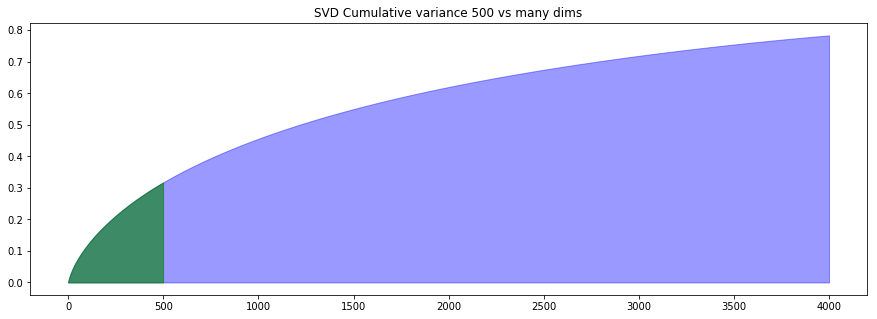

0.783907308841533

In [178]:
plt.figure(figsize=(15, 5))
plt.fill_between(np.arange(len(tsvd.explained_variance_[:500])), np.cumsum(tsvd.explained_variance_[:500]), alpha=0.6, color='green', zorder=2)
plt.fill_between(np.arange(len(tsvd.explained_variance_)), np.cumsum(tsvd.explained_variance_), alpha=0.4, color='blue', zorder=1)
plt.title('SVD Cumulative variance 500 vs many dims')
plt.show()

np.sum(tsvd.explained_variance_)

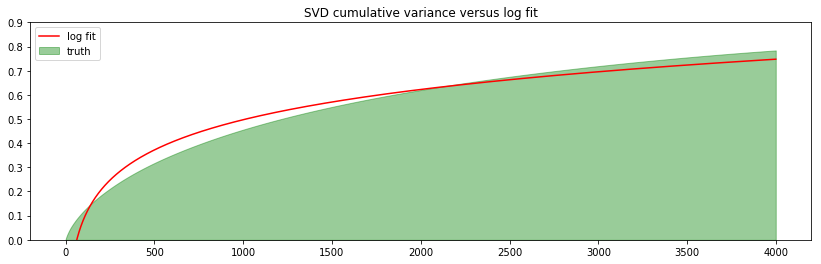

In [179]:
x = np.arange(len(tsvd.explained_variance_))
y_cdf = np.cumsum(tsvd.explained_variance_)

[c1, c2] = np.polyfit(np.log(1 + x), y_cdf, 1)

y_fit = c1 * np.log(1+x) + c2

plt.figure(figsize=(14,4))
plt.fill_between(x, y_cdf, color='green', alpha=0.4, label='truth')
plt.plot(x, y_fit, color='red', label='log fit')
plt.ylim(0, 0.9)
plt.title('SVD cumulative variance versus log fit')
plt.legend(loc='upper left')
plt.show()


The meaning of this plot: too little energy per dimension. This cumulative sucks. TD-IDF does not seem to be working well enough.

The other plot only says the cumulative energy has even worse behaviour than expected by a log fit.

### Dimensionality reduction (LSA) and normalisation

In [343]:
idx = rng.choice(term_matrix.shape[0], int(0.1 * term_matrix.shape[0]))
subsample = term_matrix[idx, :]

subsample.shape

(100000, 71030)

In [344]:
trunc = TruncatedSVD(n_components=n_comps)
norm = Normalizer(norm=l_norm)
lsa_pipe = make_pipeline(trunc, norm)
data = subsample

t0 = time.time()
term_matrix = lsa_pipe.fit_transform(data)

print('Dimensionality reduction finished after %.1fs' % (time.time() - t0))


Dimensionality reduction finished after 100.0s


# Clustering

## k-Means

### Grid search

In [176]:
# statistical results dict
# each array stores score entries for a certain number of clusters (in k_values)
km_scores_acc = {
    'inertia': [],
    'silhouette': [],
    'calinski_harabaz': []
}

# number of runs. Updated each time the next cell runs, used to average results later
n_runs = 50

In [177]:
k_values = np.arange(4, 61, 2)
batch_size = 20000
km_scores_df = pd.DataFrame(columns=('k', 'inertia', 'silhouette', 'calinski_harabaz'))
data = nmf_feats

from IPython.display import clear_output

for i in range(n_runs):
    clear_output()
    print('Starting run #%d' % (i+1))
    
    for k in k_values:
        km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
        t0 = time.time()

        km.fit(data)

        print('k-Means trained with k = %d in %.1fs' % (k, time.time() - t0))

        s_score = silhouette_score(data, km.labels_, metric='euclidean', sample_size=200)
        ch_score = calinski_harabaz_score(data, km.labels_)

        km_scores_df.loc[len(km_scores_df)] = [k, km.inertia_, s_score, ch_score]

    # adds the current score series to the accumulator
    km_scores_acc['inertia'].append(list(km_scores_df['inertia']))
    km_scores_acc['silhouette'].append(list(km_scores_df['silhouette']))
    km_scores_acc['calinski_harabaz'].append(list(km_scores_df['calinski_harabaz']))

    print('Finished run #%d' % (i+1))

print('done')

Starting run #50
k-Means trained with k = 4 in 0.8s
k-Means trained with k = 6 in 0.5s
k-Means trained with k = 8 in 0.6s
k-Means trained with k = 10 in 1.0s
k-Means trained with k = 12 in 1.1s
k-Means trained with k = 14 in 0.7s
k-Means trained with k = 16 in 0.7s
k-Means trained with k = 18 in 1.1s
k-Means trained with k = 20 in 1.0s
k-Means trained with k = 22 in 0.9s
k-Means trained with k = 24 in 1.9s
k-Means trained with k = 26 in 0.9s
k-Means trained with k = 28 in 1.9s
k-Means trained with k = 30 in 1.2s
k-Means trained with k = 32 in 1.4s
k-Means trained with k = 34 in 2.0s
k-Means trained with k = 36 in 1.2s
k-Means trained with k = 38 in 1.3s
k-Means trained with k = 40 in 1.9s
k-Means trained with k = 42 in 1.9s
k-Means trained with k = 44 in 1.4s
k-Means trained with k = 46 in 1.5s
k-Means trained with k = 48 in 3.1s
k-Means trained with k = 50 in 2.8s
k-Means trained with k = 52 in 2.1s
k-Means trained with k = 54 in 1.6s
k-Means trained with k = 56 in 2.5s
k-Means traine

### Scoring

In [ ]:
km_scores_df

In [178]:
km_score_stats = {}

# processes the score accumulator
score_avg_df = km_scores_df.groupby('k').mean()
score_std_df = km_scores_df.groupby('k').std()

for metric in ('inertia', 'silhouette', 'calinski_harabaz'):
    km_score_stats[metric] = [score_avg_df[metric], score_std_df[metric]]


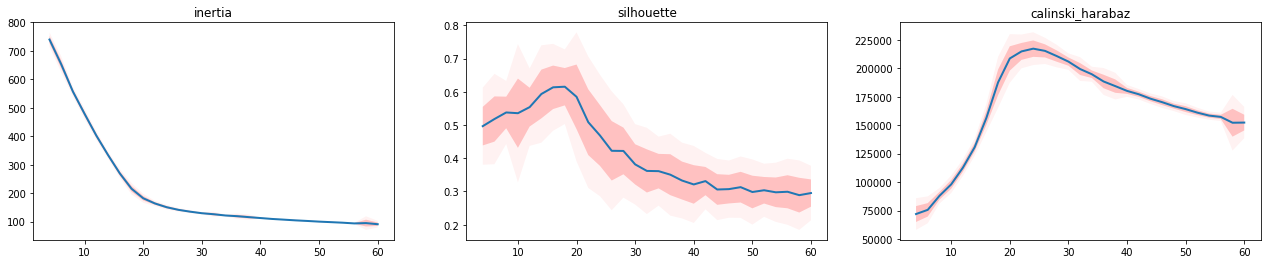

In [179]:
plt.figure(figsize=(22, 4))

for i, metric in enumerate(('inertia', 'silhouette', 'calinski_harabaz')):
    metric_avg = km_score_stats[metric][0]
    metric_std = km_score_stats[metric][1]
    
    plt.subplot(1, 3, i+1)
    plt.plot(k_values, metric_avg, linewidth=2)
    plt.fill_between(k_values, metric_avg - metric_std, metric_avg + metric_std, facecolor='red', alpha=0.2, interpolate=True)
    plt.fill_between(k_values, metric_avg - 2*metric_std, metric_avg + 2*metric_std, facecolor='red', alpha=0.05, interpolate=True)
    plt.title(metric)

plt.show()

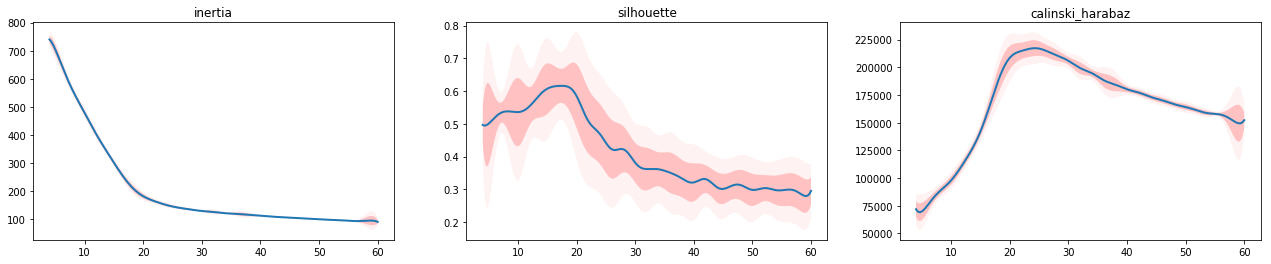

In [180]:
plt.figure(figsize=(22, 4))

for i, metric in enumerate(('inertia', 'silhouette', 'calinski_harabaz')):
    metric_avg = km_score_stats[metric][0]
    metric_std = km_score_stats[metric][1]
    
    # interpolate the error curve
    newx = np.linspace(k_values.min(), k_values.max(), 10 * (k_values.max() - k_values.min()))
    ta, ca, ka = splrep(k_values, metric_avg, s=0, k=5)
    ts, cs, ks = splrep(k_values, metric_std, s=0, k=5)
    spl_avg = BSpline(ta, ca, ka)
    spl_std = BSpline(ts, cs, ks)
    
    avg_smooth = spl_avg(newx)
    std_smooth = spl_std(newx)
    
    plt.subplot(1, 3, i+1)
    plt.plot(newx, avg_smooth, linewidth=2)
    plt.fill_between(newx, avg_smooth - std_smooth, avg_smooth + std_smooth, facecolor='red', alpha=0.2, interpolate=True)
    plt.fill_between(newx, avg_smooth - 2*std_smooth, avg_smooth + 2*std_smooth, facecolor='red', alpha=0.05, interpolate=True)
    plt.title(metric)

plt.show()

## k-Means final training

### Decide k

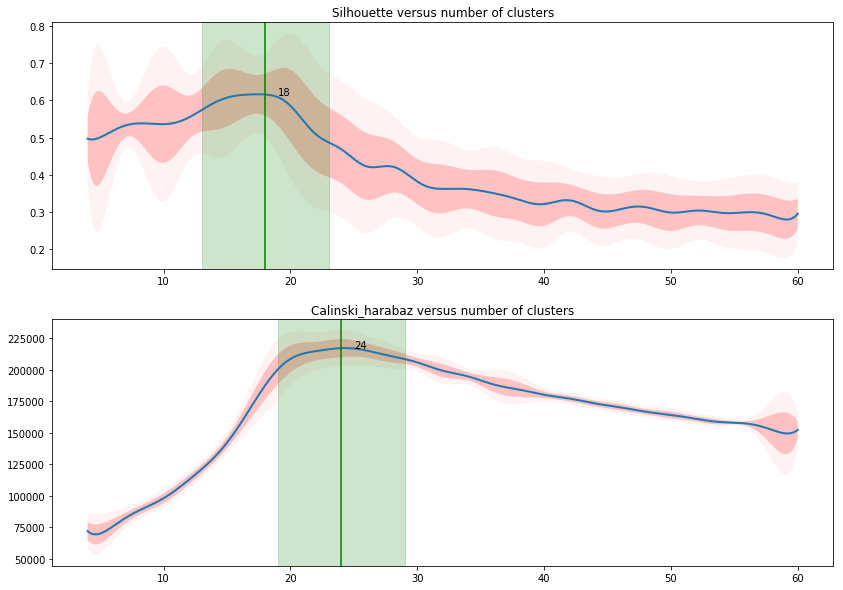

In [181]:
plt.figure(figsize=(14, 10))

# get place where silhouette/cal-hara is max and a small neighbourhood
# fill that place in the plot

for i, metric in enumerate(('silhouette', 'calinski_harabaz')):
    metric_avg = km_score_stats[metric][0]
    metric_std = km_score_stats[metric][1]
    
    # interpolate the error curve
    newx = np.linspace(k_values.min(), k_values.max(), 10 * (k_values.max() - k_values.min()))
    ta, ca, ka = splrep(k_values, metric_avg, s=0, k=5)
    ts, cs, ks = splrep(k_values, metric_std, s=0, k=5)
    spl_avg = BSpline(ta, ca, ka)
    spl_std = BSpline(ts, cs, ks)
    
    avg_smooth = spl_avg(newx)
    std_smooth = spl_std(newx)
    
    max_idx = int(metric_avg.index[metric_avg == metric_avg.max()][0])
    max_neigh = [max_idx - 5, max_idx + 5]
    
    plt.subplot(2, 1, i+1)
    plt.plot(newx, avg_smooth, linewidth=2)
    plt.fill_between(newx, avg_smooth - std_smooth, avg_smooth + std_smooth, facecolor='red', alpha=0.2, interpolate=True)
    plt.fill_between(newx, avg_smooth - 2*std_smooth, avg_smooth + 2*std_smooth, facecolor='red', alpha=0.05, interpolate=True)
    plt.axvspan(max_neigh[0], max_neigh[1], alpha=0.2, color='green')
    plt.axvline(max_idx, color='green')
    plt.annotate(str(int(max_idx)), (max_idx+1, metric_avg[max_idx]))
    plt.title(metric.capitalize() + ' versus number of clusters')

plt.show()


In [182]:
# for inertia, we gotta do a double linear fit to decide the centre of the neighbourhood

from scipy.stats import linregress

lines = []

for mid in np.arange(8, len(k_values) - 1):
    x1 = k_values[0:mid]
    x2 = k_values[mid:]
    y1 = km_score_stats['inertia'][0][x1]
    y2 = km_score_stats['inertia'][0][x2]
    
    a1, b1, rv1, _, _ = linregress(x1, y1)
    a2, b2, rv2, _, _ = linregress(x2, y2)
    
    rv = np.mean([rv1**2, rv2**2])
    
    lines.append([a1, b1, a2, b2, rv1**2, rv2**2, rv, mid])


In [183]:
lines_df = pd.DataFrame(np.matrix(lines), columns=('a1', 'b1', 'b2', 'b2', 'rv1', 'rv2', 'rv', 'mid'))

best = lines_df[lines_df['rv'] == lines_df['rv'].max()]

best

,a1,b1,b2,b2,rv1,rv2,rv,mid
2,-32.994679,828.266479,-1.494438,175.572479,0.972598,0.94854,0.960569,10.0


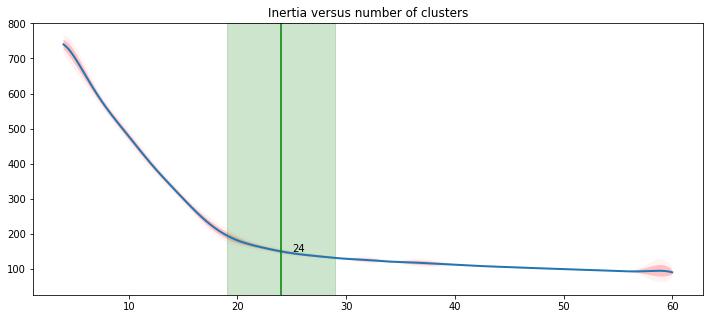

In [184]:
plt.figure(figsize=(12, 5))

metric_avg = km_score_stats['inertia'][0]
metric_std = km_score_stats['inertia'][1]

# interpolate the error curve
newx = np.linspace(k_values.min(), k_values.max(), 10 * (k_values.max() - k_values.min()))
ta, ca, ka = splrep(k_values, metric_avg, s=0, k=5)
ts, cs, ks = splrep(k_values, metric_std, s=0, k=5)
spl_avg = BSpline(ta, ca, ka)
spl_std = BSpline(ts, cs, ks)

avg_smooth = spl_avg(newx)
std_smooth = spl_std(newx)
best = k_values[int(best['mid'])]

plt.plot(newx, avg_smooth, linewidth=2)
plt.fill_between(newx, avg_smooth - std_smooth, avg_smooth + std_smooth, facecolor='red', alpha=0.2, interpolate=True)
plt.fill_between(newx, avg_smooth - 2*std_smooth, avg_smooth + 2*std_smooth, facecolor='red', alpha=0.05, interpolate=True)
plt.axvspan(best - 5, best + 5, alpha=0.2, color='green')
plt.axvline(best, color='green')
plt.annotate(str(best), (max_idx+1, metric_avg[max_idx]))
plt.title(metric)

plt.title('Inertia versus number of clusters')
plt.show()

### Fit k-Means

In [185]:
km = KMeans(n_clusters=21, n_jobs=4, n_init=20, max_iter=500, algorithm='full')
data = nmf_feats

t0 = time.time()
km.fit(data)

print('k-Means trained in %.1fs' % (time.time() - t0))
km.inertia_

k-Means trained in 69.5s


163.8289939691475

In [186]:
# Now praying that order was preserved throughout the
# feature extraction pipeline, we call upon this:

cluster_df = df[['publish_date', 'headline_text', 'headline_pprocd']].copy()

cluster_df['cluster_id'] = pd.Series(km.labels_)

cluster_df.sample(10)

,publish_date,headline_text,headline_pprocd,cluster_id
146477,2005-03-27,hawks get off to horror start,hawk get horror start,1
113429,2004-10-19,australia joins exercise off japan despite n korea,australia join exercise japan despite n korea,4
235472,2006-03-22,new board to give youth a say,new board give youth say,10
345426,2008-05-15,budget reply to test nelsons leadership,budget reply test nelson leadership,1
350091,2008-02-24,mcleods daughters attracts jillaroos to the bush,mcleods daughter attracts jillaroos bush,1
139161,2005-08-07,coonan sees learning curve for telstra boss,coonan see learning curve telstra bos,1
647814,2012-06-10,the hit up,hit,1
62796,2004-10-02,phallic political artwork raises eyebrows,phallic political artwork raise eyebrow,1
663847,2012-09-10,a long wait for new tanami tenements,long wait new tanami tenement,6
555921,2011-07-08,chaplain says heyward was mistreated,chaplain say heyward mistreated,10


In [187]:
# need most common words in each cluster
def get_n_most_freq_words(corpus, n):
    cluster_counter = CountVectorizer(ngram_range=(1, 1))
    bow = cluster_counter.fit_transform(corpus)
    word_count = bow.sum(axis=0)
    total = np.sum(word_count)
    words_freq = [(word, word_count[0, idx] / total) for word, idx in cluster_counter.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]


In [189]:
freq = []

for i in (4, 6, 7, 12, 21):
    subdf = cluster_df[cluster_df['cluster_id'] == i-1]['headline_pprocd']
    freq.append(get_n_most_freq_words(subdf, 5))

freq

[[('police', 0.17763291139240506),
  ('man', 0.014481012658227849),
  ('probe', 0.009582278481012658),
  ('investigate', 0.009012658227848101),
  ('missing', 0.008151898734177215)],
 [('council', 0.17995724080308653),
  ('plan', 0.014130194382326199),
  ('new', 0.006929938810114762),
  ('rate', 0.006549037918069447),
  ('seek', 0.0056397906273806305)],
 [('new', 0.16786101742448284),
  ('zealand', 0.007070162879430845),
  ('year', 0.006273109026634883),
  ('law', 0.006243588513568366),
  ('get', 0.004250953881578462)],
 [('win', 0.17205723217506314),
  ('award', 0.007988991757177401),
  ('title', 0.006345771044580712),
  ('gold', 0.0060652211668203015),
  ('cup', 0.005423964303367935)],
 [('plan', 0.17408133707591547),
  ('govt', 0.00743389600235834),
  ('new', 0.00695966470565617),
  ('group', 0.003998923366785865),
  ('health', 0.00364004562874098)]]

In [191]:
sentences = []

for i in (4, 6, 7, 12, 21):
    subdf = cluster_df[cluster_df['cluster_id'] == i-1]['headline_text'].sample(5)
    sentences.append(subdf)

sentences

[935117    police defend questioning paddington restaurant over wine list
 986347           facebook post from tas police after driver lucky escape
 68783                      police investigate fatal hit and run accident
 31019                            wa police praise well behaved schoolies
 255257                police seeking three others heyward murder hearing
 Name: headline_text, dtype: object,
 928619    buloke shire maitreya festival decision sparks council tilt
 120259               albany council to discuss marina recommendations
 823409                 council flags hope for development of dunes 18
 496898                        council drops plans to sell crematorium
 509945                                  mayor attacks council bashing
 Name: headline_text, dtype: object,
 410148                 darwin elects new deputy lord mayor
 496132                 tim mathieson new patron of gallery
 425275      riverina enters new year with relatively quiet
 719715    new book r

In [79]:
date_idx = (cluster_df['publish_date'] >= '2015-01-01') & (cluster_df['publish_date'] < '2016-01-01')
cluster_df[date_idx & (cluster_df['cluster_id'] == 1)]['headline_text'].sample(20)

879088             taxi industry green paper not yet discussed nalder says
902184         plans for act public housing overhaul to go ahead barr says
871843       growers say canola production down in sa due to gm moratorium
842366        finks bikie eating pie at time of alleged attack lawyer says
898309                   east timors former president says west papua part
841534         malcolm turnbull says federal election around sept oct 2016
902631                                            boom imminent says agent
870814                   queensland budget mean and tricky opposition says
900900          scott morrison says he knows whether people smugglers paid
887483    clear vision needed before se qld bid for 2028 olympics qtic say
898051       gm crop fight farmers say heartache could have been prevented
853738              poland co responsible for wwii says russian ambassador
886215                 bolt says pms knightmare could be politically fatal
898190            egg far

2003

### t-SNE sucked

In [49]:
idx = rng.choice(term_matrix.shape[0], int(0.01 * term_matrix.shape[0]))
subsample = nmf_feats[idx, :]

tsne_nme = TSNE(n_components=2, verbose=1).fit_transform(subsample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 2.711s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.501312
[t-SNE] Error after 1000 iterations: 1.149340


In [43]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
#colormap = colormap[:21]

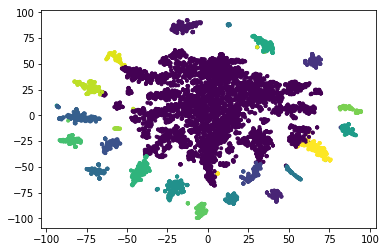

In [50]:
plt.scatter(tsne_nme[:,0], tsne_nme[:,1], c=km.labels_[idx], marker='.')

### Evaluate terms found inside calculated clusters

In [33]:
(1.5*24 + 1.5*22 + 16)/4

21.25

## Meanshift

### Grid search

In [ ]:
# Bandwidth estimation can be a serious bottleneck, so we are checking it first. Best time vs consistent value wins
quantiles = np.arange(0.1, 0.5, 0.1)
n_samples = np.array([100, 500, 1000, 2000, 3000, 4000, 5000])
bw_bench_df = pd.DataFrame(columns=('n_samples', 'quantile', 'bandwidth', 'elapsed_time'))
iteration = 1
data = term_matrix

for q in quantiles:
    for n in n_samples:
        t0 = time.time()
        bw = estimate_bandwidth(data, quantile=q, n_samples=n, n_jobs=4)
        elapsed = time.time() - t0
        bw_bench_df.loc[len(bw_bench_df)] = [n, q, bw, elapsed]
        
        print('bandwidth calculation %d/%d benchmark pair (%.1f, %d) finished in %.1fs' % (iteration, 
            len(quantiles) * len(n_samples), q, n, elapsed))
        
        iteration += 1

print('done')
bw_bench_df

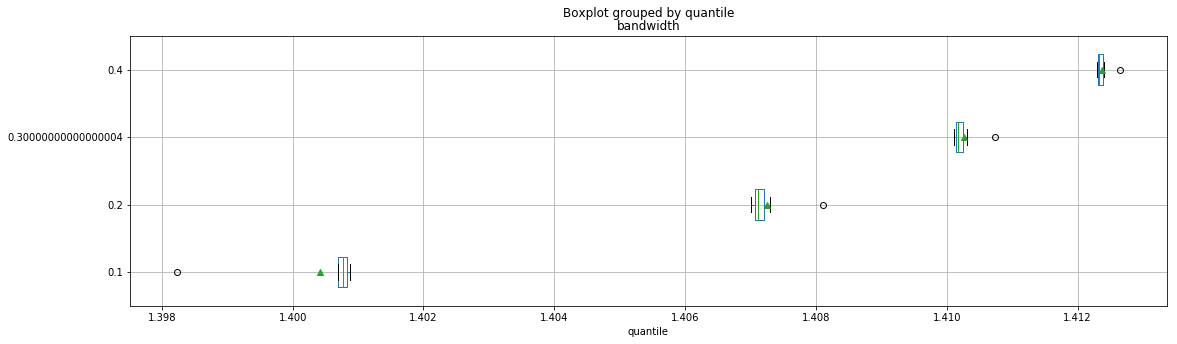

In [193]:
# Bandwidth benchmarking plot
bw_bench_df.boxplot(column='bandwidth', by='quantile', figsize=(18,5), showmeans=True, vert=False)

Conclusion from this plot: visually, the number of samples did not seem to change much the calculated bandwidth. Therefore, any value with the bigest sample size which performs well in time would suffice.

In [285]:
ms_scores_df = pd.DataFrame(columns=('bw_factor', 'bandwidth', 'estimated_k', 'silhouette', 'calinski_harabaz'))
bw_values = [np.min(bw_bench_df['bandwidth']), np.median(bw_bench_df['bandwidth']), np.max(bw_bench_df['bandwidth'])]
bw_factors = [0.5, 0.6]
bw_grid = np.array(np.meshgrid(bw_factors, bw_values)).T.reshape(-1, 2)
data = term_matrix

for bwf, bwv in bw_grid:
    ms = MeanShift(bandwidth=bwf * bwv, bin_seeding=True, n_jobs=4)
    t0 = time.time()
    
    ms.fit(data)
    
    print('Meanshift trained with bw = %.3f * %.3f = %.3f in %.1fs' % (bwf, bwv,
        bwf * bwv, time.time() - t0))
    
    if len(ms.cluster_centers_) == 1:
        print('Ignoring this training, it found only 1 cluster')
        continue
    
    ms_scores_df.loc[len(ms_scores_df)] = [bwf, bwf * bwv, len(ms.cluster_centers_),
        silhouette_score(data, ms.labels_, sample_size=200),
        calinski_harabaz_score(data, ms.labels_)]

print('done')

Meanshift trained with bw = 0.500 * 1.398 = 0.699 in 212.9s
Meanshift trained with bw = 0.500 * 1.409 = 0.705 in 204.3s
Meanshift trained with bw = 0.500 * 1.413 = 0.706 in 202.9s
Meanshift trained with bw = 0.600 * 1.398 = 0.839 in 73.7s
Meanshift trained with bw = 0.600 * 1.409 = 0.845 in 70.7s
Meanshift trained with bw = 0.600 * 1.413 = 0.848 in 70.8s
done


In [240]:
ms = MeanShift(bandwidth=0.6*bw_values[0], bin_seeding=True, n_jobs=4)
t0 = time.time()
ms.fit(term_matrix)
ms.cluster_centers_.shape

MeanShift(bandwidth=0.8389402997744785, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=4, seeds=None)

### Scoring

The *Silhouette coefficient* goes from -1 (incorrect clustering) to +1 (high density clusters). Values near 0 indicate overlapping clusters. Favours convex clusters.

The *Calinski-Harabaz index* is higher the more dense and well separated the clusters are. Also favours convex clusters.

In [286]:
ms_scores_df

,bw_factor,bandwidth,estimated_k,silhouette,calinski_harabaz
0,0.5,0.699117,12.0,0.001680,189.415253
1,0.5,0.704553,13.0,0.006606,190.361021
2,0.5,0.706322,13.0,0.015255,189.369235
3,0.6,0.838940,24.0,0.015247,164.997519
4,0.6,0.845464,23.0,0.009237,167.991600
5,0.6,0.847586,23.0,0.017852,169.265285


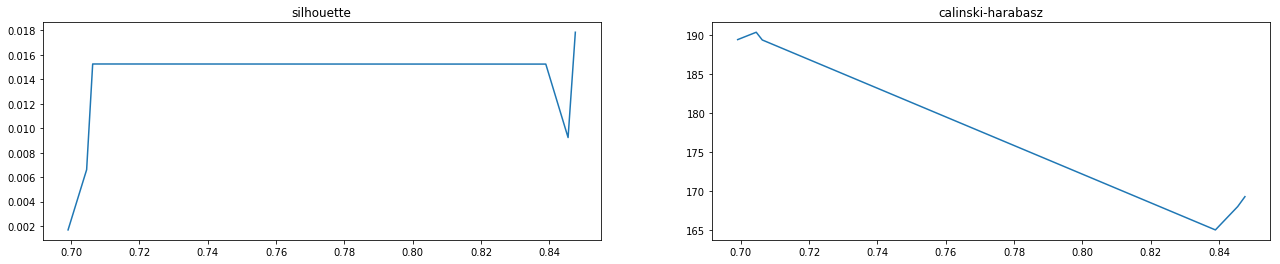

In [287]:
plt.figure(figsize=(22,4))
plt.subplot(1, 2, 1)
plt.plot(ms_scores_df['bandwidth'], ms_scores_df['silhouette'])
plt.title('silhouette')
plt.subplot(1, 2, 2)
plt.plot(ms_scores_df['bandwidth'], ms_scores_df['calinski_harabaz'])
plt.title('calinski-harabasz')
plt.show()

## DBSCAN (WARN: THE GRID SEARCH IS TAKING THE WHOLE RAM!

## Grid search

In [ ]:
leaf_sizes = np.arange(10, 31, 10)
eps_vals = np.arange(0.1, 0.51, 0.1)
msamples = np.arange(10, 31, 10)
param_grid = np.array(np.meshgrid(leaf_sizes, eps_vals, msamples)).T.reshape(-1, 3)
db_score_df = pd.DataFrame(columns=('estimated_k', 'eps', 'min_samples', 'leaf_size', 'silhouette', 'calinski-harabaz'))
data = term_matrix

for l, e, s in param_grid:
    db = DBSCAN(eps=l, min_samples=s, metric='minkowski', p=2, algorithm='ball_tree', leaf_size=l, n_jobs=4)

    t0 = time.time()
    db.fit(data)
    
    print('DBSCAN (leafs, eps, samples) = (%d, %.1f, %d) trained in %.1fs' % (l, e, s, time-time() - t0))
    
    # according to documentation:
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    db_score_df.loc[len(db_score_df)] = [n_clusters, e, s, l,
        silhouette_score(data, db.labels_, sample_size=200),
        calinski_harabaz_score(data, db.labels_)]

print('done')

array([1, 1, 0, 1])

## My clustering evaluation metric
"My" as in "I don't know if someone came up with this before, I just had this idea."

In [72]:
from sklearn.neighbors import KNeighborsClassifier

def knn_mismatch_score(X, labels, lnorm=2, weights='uniform'):
    '''
    Receives a data matrix X and (supposedly) predicted labels that cluster the data in X.
    
    It then uses a k-NN algorithm to re-label X and calculates the score as the number of mismatches
    between these labels and those given as parameter.
    '''
    unique_labels = np.unique(labels)
    knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', weights=weights, n_jobs=4, p=lnorm)
    
    knn.fit(X, labels)
    
    pred_labels = knn.predict(X)
    
    score = np.sum(np.equal(pred_labels, labels).astype(int)) / len(labels)
    
    return score


In [73]:
# a 5-minute test on predicted labels by a km and ms using UNIFORM weights
t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, km.labels_, weights='uniform'))
print('knn mismatch score on km finished in %.1fs' % (time.time() - t0))

t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, ms.labels_, weights='uniform'))
print('knn mismatch score on ms finished in %.1fs' % (time.time() - t0))

0.8958852021185097
knn mismatch score on km finished in 333.4s
0.8981259336381332
knn mismatch score on ms finished in 336.5s


In [74]:
# a 5-minute test on predicted labels by a km and ms using INVERSE DISTANCE weights
t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, km.labels_, weights='distance'))
print('knn mismatch score on km finished in %.1fs' % (time.time() - t0))

t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, ms.labels_, weights='distance'))
print('knn mismatch score on ms finished in %.1fs' % (time.time() - t0))

1.0
knn mismatch score on km finished in 332.5s
1.0
knn mismatch score on ms finished in 341.8s
